In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import itertools
import time

In [17]:
df = pd.read_csv('datasets/us_accidents_expanded.csv')

## Machine Learning 2
A different approach to ML models

### Dataset Processing
Before we can try out machine learning models, we need to first prepare our dataset.
The first thing is to drop features that we don't believe are necessary.

In [18]:
df_ml = df.copy()

# dropping timestamps for now, relying on elapsed time instead
df_ml.drop(columns=['Start_Datetime', 'End_Datetime', 'Start_Date', 'End_Date', 'Start_Time', 'End_Time'], inplace=True)

# dropping exact coordinates, relying on distance instead
df_ml.drop(columns=['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng'], inplace=True)

# description, address, weather timestamp, and airport don't provide any meaningful information
df_ml.drop(columns=['Description', 'Street', 'City', 'County', 'Zipcode', 'Weather_Timestamp', 'Airport_Code'], inplace=True)

# temp: drop elapsed time cause it's bugged
df_ml.drop(columns=['Elapsesd_Time'], inplace=True)

Next we need to adjust the day/night features to true/false respectively.

In [19]:
# change day/night to true/false respectively
day_night = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
df_ml[day_night] = df_ml[day_night].replace('Day', True)
df_ml[day_night] = df_ml[day_night].replace('Night', False)

We also need to drop records containing missing values. We've imputed what we can 
during the dataset processing, we now we just drop the remaining ones.

In [20]:
df_ml.dropna(inplace=True)

Finally, we need to convert the `Severity` target feature to string so it's
treated as a discrete class value.

In [21]:
df_ml['Severity'] = df_ml['Severity'].astype(str)

We can now split into `X` (features) and `y` (target class) for training.

In [22]:
X = df_ml.drop(columns=['Severity'])
y = df_ml['Severity']

### Train/Val/Test Split
We initially wanted to use cross validation to test our models. However, due to 
the sheer size of our dataset, it would be very time intensive. Instead, our plan
is to split the dataset into training, validation, and testing. Training and validation
sets will be used to gauge performances of various models. Once we determine the best
model, we'll run it one last time on the test set. The split we use for train/val/test
will be 70/20/10.

In [23]:
# split off testing data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

# split rest into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=2/9, random_state=1234)

Before we start to train our models, we need to normalize our numerical data. We will
use sklearn's `MinMaxScaler` for this.

In [24]:
scaler = MinMaxScaler()
numeric_columns = df_ml.select_dtypes(include=['number']).columns
print('Normalizing the following columns:')
for col in numeric_columns:
    print(f' - {col}')

X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

Normalizing the following columns:
 - Distance(mi)
 - Temperature(F)
 - Wind_Chill(F)
 - Humidity(%)
 - Pressure(in)
 - Visibility(mi)
 - Wind_Speed(mph)
 - Precipitation(in)


Our final processed dataset looks something like this:

In [25]:
X_train.head()

,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,...,Region_West,Division_East North Central,Division_East South Central,Division_Middle Atlantic,Division_Mountain,Division_New England,Division_Pacific,Division_South Atlantic,Division_West North Central,Division_West South Central
214985,0.014837,0.395556,0.451613,0.683673,0.919795,0.100,0.020576,0.000000,False,False,...,False,False,False,True,False,False,False,False,False,False
317281,0.006614,0.297778,0.350806,0.602041,0.878840,0.100,0.020576,0.000000,False,False,...,False,False,False,False,False,False,False,False,False,True
105583,0.004035,0.524444,0.568548,0.581633,0.912969,0.100,0.024691,0.000000,False,False,...,False,False,False,False,False,False,False,False,False,True
405621,0.000534,0.244444,0.266129,0.775510,0.883106,0.005,0.057613,0.000991,False,False,...,False,False,False,True,False,False,False,False,False,False
484393,0.011163,0.328889,0.391129,0.479592,0.805461,0.100,0.000000,0.000000,False,False,...,False,False,False,False,False,False,False,True,False,False


### Logistic Regression

In [26]:
solvers = ['saga', 'sag', 'newton-cg']

best_lr_model = None
best_lr_solver = None
best_lr_acc = 0.0
lr_acc = []

for solver in solvers:
    # set up logistic regressor
    logreg = LogisticRegression(
        solver=solver,
        random_state=1234,
        multi_class='multinomial',
        max_iter=250,
        n_jobs=-2
    )

    # train logistic regressor
    start_time = time.time()
    logreg.fit(X_train, y_train)
    acc = logreg.score(X_val, y_val)
    end_time = time.time()
    # get results
    print(f'Solver {solver} ({end_time - start_time:.1f}s): {acc}')
    lr_acc.append(acc)

    # save best
    if acc > best_lr_acc:
        best_lr_model = logreg
        best_lr_acc = acc
        best_lr_solver = solver

print('=============')
print(f'Best logistic regressor solver is {best_lr_solver} with an accuracy of {best_lr_acc}')

Solver saga (110.9s): 0.846520714819284
Solver sag (52.7s): 0.8465063494799747
Solver newton-cg (178.6s): 0.846520714819284
Best logistic regressor solver is saga with an accuracy of 0.846520714819284


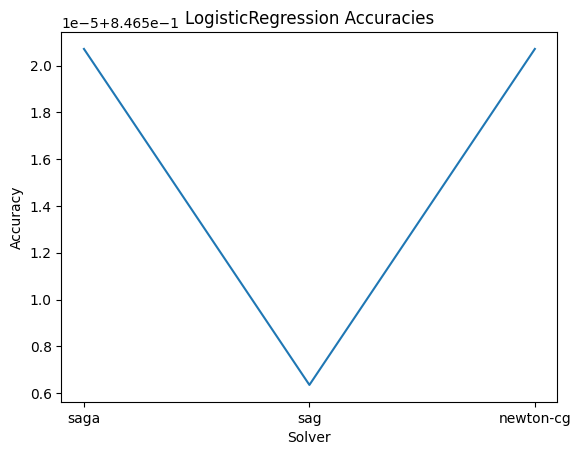

In [27]:
plt.plot(solvers, lr_acc)
plt.title('LogisticRegression Accuracies')
plt.xlabel('Solver')
plt.ylabel('Accuracy');

### Decision Tree
Next is a **Decision Tree** classifier.

In [28]:
criterion = ['gini', 'entropy']
max_depth = [10, 20, None]
min_samples_split = [2, 0.0001]
min_samples_leaf = [1, 5, 10]
max_features = [None, 'sqrt', 'log2']

dt_combos = list(itertools.product(criterion, max_depth, min_samples_split, min_samples_leaf, max_features))

best_dt_model = None
best_dt_param = None
best_dt_acc = 0.0
for combo in dt_combos:
    # set up tree model
    c, md, mss, msl, mf = combo
    tree = DecisionTreeClassifier(
        criterion=c,
        max_depth=md,
        min_samples_split=mss,
        min_samples_leaf=msl,
        max_features=mf,
        random_state=1234
    )
    
    # train decision tree
    start_time = time.time()
    tree.fit(X_train, y_train)
    acc = tree.score(X_val, y_val)
    end_time = time.time()
    
    # get results
    print(f'Param {combo} ({end_time - start_time:.1f}s): {acc}')

    # save best
    if acc > best_dt_acc:
        best_dt_model = tree
        best_dt_acc = acc
        best_dt_param = combo

print('=============')
print(f'Best decision tree params are {best_dt_param} with an accuracy of {best_dt_acc}')

Param ('gini', 10, 2, 1, None) (4.7s): 0.8564184336034018
Param ('gini', 10, 2, 1, 'sqrt') (1.6s): 0.8491352065735792
Param ('gini', 10, 2, 1, 'log2') (1.2s): 0.845788082514509
Param ('gini', 10, 2, 5, None) (4.3s): 0.8567919324254439
Param ('gini', 10, 2, 5, 'sqrt') (1.1s): 0.84912084123427
Param ('gini', 10, 2, 5, 'log2') (1.0s): 0.8460466586220766
Param ('gini', 10, 2, 10, None) (4.1s): 0.8568350284433718
Param ('gini', 10, 2, 10, 'sqrt') (1.1s): 0.8495087053956214
Param ('gini', 10, 2, 10, 'log2') (0.9s): 0.8461615813365512
Param ('gini', 10, 0.0001, 1, None) (4.1s): 0.8566051830144228
Param ('gini', 10, 0.0001, 1, 'sqrt') (1.1s): 0.848531862322588
Param ('gini', 10, 0.0001, 1, 'log2') (0.9s): 0.8458455438717463
Param ('gini', 10, 0.0001, 5, None) (4.7s): 0.856748836407516
Param ('gini', 10, 0.0001, 5, 'sqrt') (1.1s): 0.8486324196977533
Param ('gini', 10, 0.0001, 5, 'log2') (1.0s): 0.8459173705682929
Param ('gini', 10, 0.0001, 10, None) (4.4s): 0.8568781244612997
Param ('gini', 10,

### Neural Network

In [29]:
nn_sizes = {
    'A1': (20),
    'A2': (50),
    'A3': (100),
    'A4': (200),
    'A5': (50,50),
    'A6': (100,50),
    'A7': (100,100),
    'A8': (200,100),
    'A9': (100,100,100),
    'A10': (50,100,50),
    'A11': (100,100,50),
    'A12': (100,100,100),
    'A13': (100,150,100),
    'A14': (50, 100, 100, 50)
}

best_nn_model = None
best_nn_size = None
best_nn_acc = 0.0

nn_acc = []
for case, size in nn_sizes.items():
    # set up MLP
    mlp = MLPClassifier(
        hidden_layer_sizes=size,
        alpha=0.01,
        random_state=1234,
        early_stopping=True
    )

    # train MLP
    start_time = time.time()
    mlp.fit(X_train, y_train)
    acc = mlp.score(X_val, y_val)
    end_time = time.time()

    # get results
    print(f'{case} {size} ({end_time - start_time:.1f}s): {acc}')
    nn_acc.append(acc)

    # save best
    if acc > best_nn_acc:
        best_nn_model = mlp
        best_nn_acc = acc
        best_nn_size = size

print('=============')
print(f'Best neural network design is {best_nn_size} with an accuracy of {best_nn_acc}')

A1 20 (19.7s): 0.8476412112854106
A2 50 (35.1s): 0.8470378670344193
A3 100 (152.2s): 0.8485605930012067
A4 200 (50.8s): 0.8477130379819572
A5 (50, 50) (77.0s): 0.8485031316439694
A6 (100, 50) (229.2s): 0.8498103775211171
A7 (100, 100) (157.4s): 0.8516922369706372
A8 (200, 100) (304.7s): 0.8497672815031891
A9 (100, 100, 100) (306.8s): 0.8498103775211171
A10 (50, 100, 50) (208.7s): 0.8514336608630696
A11 (100, 100, 50) (346.5s): 0.8491352065735792
A12 (100, 100, 100) (301.8s): 0.8498103775211171
A13 (100, 150, 100) (390.3s): 0.850313164396943
A14 (50, 100, 100, 50) (235.0s): 0.8507728552548411
Best neural network design is (100, 100) with an accuracy of 0.8516922369706372


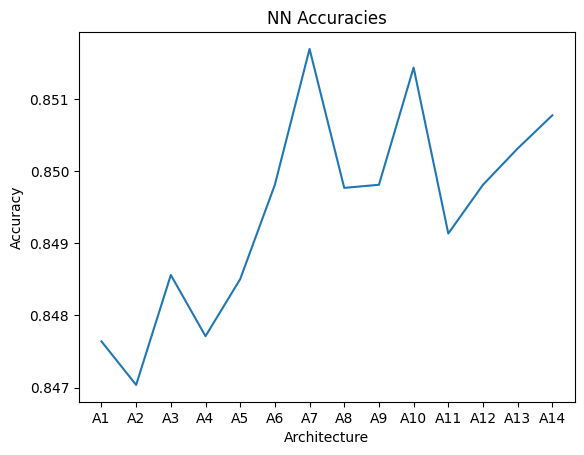

In [30]:
plt.plot(nn_sizes.keys(), nn_acc)
plt.title('NN Accuracies')
plt.xlabel('Architecture')
plt.ylabel('Accuracy');

### KNN

In [31]:
k_values = np.arange(1, 26, 2)

best_knn_model = None
best_k = 0
best_knn_acc = 0.0
knn_acc = []

for k in k_values:
    # set up KNN
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-2)

    # train KNN
    start_time = time.time()
    knn.fit(X_train, y_train)
    acc = knn.score(X_val, y_val)
    end_time = time.time()

    # get results
    print(f'K={k} ({end_time - start_time:.1f}s): {acc}')
    knn_acc.append(acc)

    # save best
    if acc > best_knn_acc:
        best_knn_model = knn
        best_knn_acc = acc
        best_k = k

print('=============')
print(f'Best k-value is {best_k} with an accuracy of {best_knn_acc}')

K=1 (97.6s): 0.7598977187841177
K=3 (94.6s): 0.8135953571223352
K=5 (97.7s): 0.8317818766879274
K=7 (95.2s): 0.8379877032695512
K=9 (96.8s): 0.8407314830776303
K=11 (98.3s): 0.8425558811699132
K=13 (98.0s): 0.844006780440154
K=15 (95.5s): 0.8447106820663104
K=17 (96.8s): 0.8457306211572717
K=19 (98.8s): 0.8463052347296444
K=21 (93.3s): 0.8464201574441188
K=23 (97.9s): 0.8466787335516864
K=25 (95.3s): 0.846520714819284
Best k-value is 23 with an accuracy of 0.8466787335516864


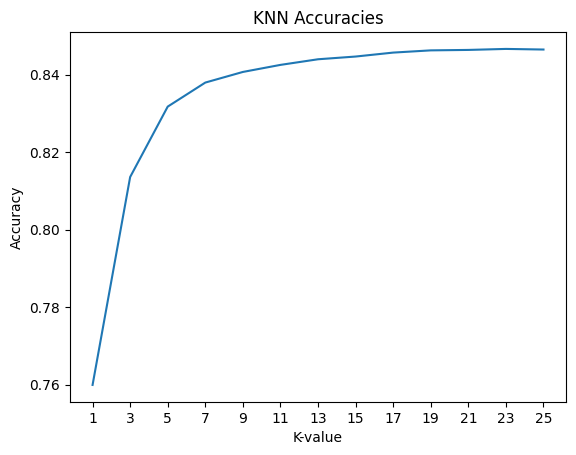

In [32]:
plt.plot([str(k) for k in k_values], knn_acc)
plt.title('KNN Accuracies')
plt.xlabel('K-value')
plt.ylabel('Accuracy');

Although accuracy continues to increase as `k` increase, we can see that we start
to get diminishing returns. The tiny increase in accuracy is not worth the increased
complexity and train time. We can treat this graph like a scree plot, with the elbow
being around `k=7`. Therefore, we will use that value as our most optimal k-value
rather than choosing the one with the highest accuracy.

In [33]:
best_k=7
best_knn_model = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-2)
best_knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-2, n_neighbors=7)

### Comparison
Before we choose the final model, we should evaluate the precision and recall
for each model type.

In [34]:
display_labels=['Severity 1','Severity 2','Severity 3','Severity 4']

#### Logistic Regression

c:\Users\Me\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.33871910685095374
Recall:    0.26046305791877805
F1:        0.25109693023114776


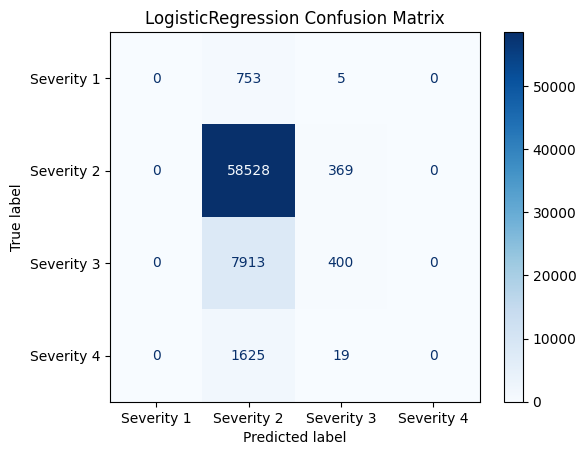

In [35]:
lr_pred = best_lr_model.predict(X_val)

# metrics
lr_precision = precision_score(y_val, lr_pred, average='macro')
lr_recall = recall_score(y_val, lr_pred, average='macro')
lr_f1 = f1_score(y_val, lr_pred, average='macro')
print(f'Precision: {lr_precision}')
print(f'Recall:    {lr_recall}')
print(f'F1:        {lr_f1}')

# confusion matrix
cm = confusion_matrix(y_val, lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('LogisticRegression Confusion Matrix');


#### Decision Tree

Precision: 0.5542995466820013
Recall:    0.30958112137502086
F1:        0.3307984888841262


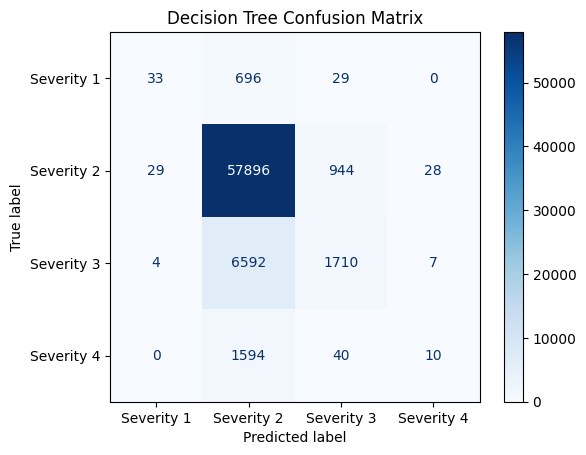

In [36]:
dt_pred = best_dt_model.predict(X_val)

# metrics
dt_precision = precision_score(y_val, dt_pred, average='macro')
dt_recall = recall_score(y_val, dt_pred, average='macro')
dt_f1 = f1_score(y_val, dt_pred, average='macro')
print(f'Precision: {dt_precision}')
print(f'Recall:    {dt_recall}')
print(f'F1:        {dt_f1}')

# confusion matrix
cm = confusion_matrix(y_val, dt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix');

#### Neural Network

Precision: 0.721826059204204
Recall:    0.2882989358771498
F1:        0.29618277344086846


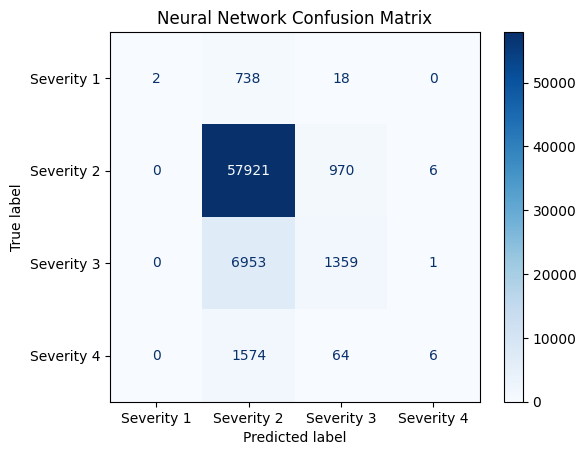

In [37]:
nn_pred = best_nn_model.predict(X_val)

# metrics
nn_precision = precision_score(y_val, nn_pred, average='macro')
nn_recall = recall_score(y_val, nn_pred, average='macro')
nn_f1 = f1_score(y_val, nn_pred, average='macro')
print(f'Precision: {nn_precision}')
print(f'Recall:    {nn_recall}')
print(f'F1:        {nn_f1}')

# confusion matrix
cm = confusion_matrix(y_val, nn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix');

#### KNN

Precision: 0.37508763395658684
Recall:    0.27236348563103663
F1:        0.27387969432130393


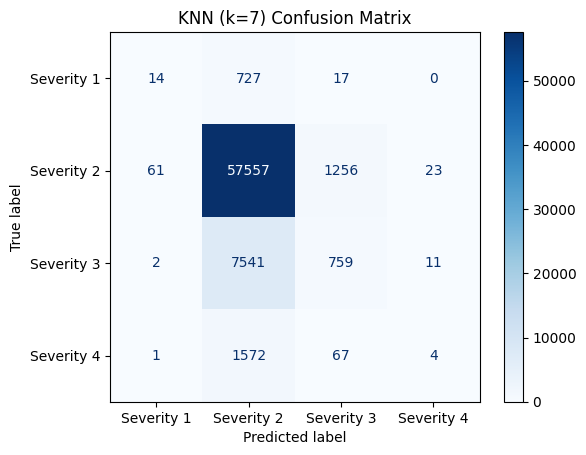

In [38]:
knn_pred = best_knn_model.predict(X_val)

# metrics
knn_precision = precision_score(y_val, knn_pred, average='macro')
knn_recall = recall_score(y_val, knn_pred, average='macro')
knn_f1 = f1_score(y_val, knn_pred, average='macro')
print(f'Precision: {knn_precision}')
print(f'Recall:    {knn_recall}')
print(f'F1:        {knn_f1}')

# confusion matrix
cm = confusion_matrix(y_val, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'KNN (k={best_k}) Confusion Matrix');

### Final Test Performance
In the end, the best performing model was the decision tree. It had the best overall
accuracy and F1 score. We can now run it on the test dataset and evaluate the performance.

Precision: 0.5349653583557443
Recall:    0.3064445327655791
F1:        0.32585653722695307


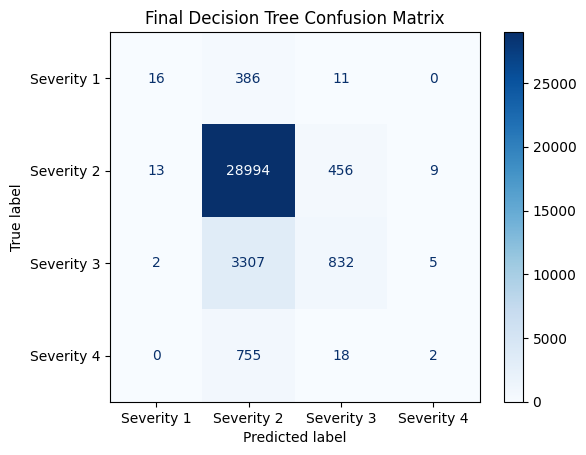

In [43]:
final_acc = best_dt_model.score(X_test, y_test)
test_pred = best_dt_model.predict(X_test)

final_precision = precision_score(y_test, test_pred, average='macro')
final_recall = recall_score(y_test, test_pred, average='macro')
final_f1 = f1_score(y_test, test_pred, average='macro')
print(f'Precision: {final_precision}')
print(f'Recall:    {final_recall}')
print(f'F1:        {final_f1}')

cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Final Decision Tree Confusion Matrix');